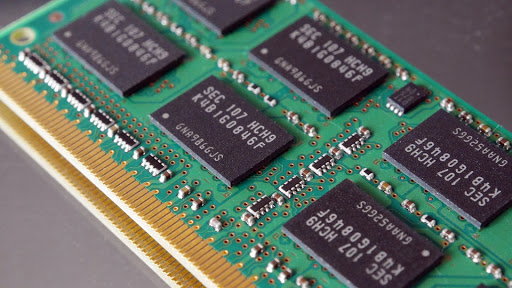

![](http://retrofittingca.com/wp-content/uploads/2017/02/PROOFED-RetrofittingCA-WhyEarthquakesAreSoHardtoPredictJanuary312017-PIC.jpg)


# How to handle memory in python

 <a id="top"></a> <br>
## Notebook  Content
1. [Memory issues](#1)
1. [EDA-briefly](#2)
1. [Feature Engineering (to be continued) ](#3)


In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import gc

<a id="1"></a> <br>
#  1-Memory issues

In [ ]:
%%time
train = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

First potential problem will be definately memory usage. WE have over 629 **Milion** rows of date, and as we can see even with pre-setting data-types it takes a couple of minutes. Right of the bat 10GB is taken. We can fight it with following approaches:

*  **DASK** ---("A Dask DataFrame is a large parallel dataframe composed of many smaller Pandas dataframes, split along the index. These pandas dataframes may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster. One Dask dataframe operation triggers many operations on the constituent Pandas dataframes.") [Dask-doc]((http://docs.dask.org/en/latest/dataframe.html) **NUTSHELL:**  python library for parallel computing that can work on a single notebook or large cluster and will compute the operations (careful not all of them) very fast
* ** Garbage Collector** (gc()) and deleting unused variables
*  **Pre-setting data types** when importing (as above)
* **Custom Function** to reduce memory (to be found in 2. EDA section)



In [ ]:
import dask
import dask.dataframe as dd

In [ ]:
%%time
train1 = dd.read_csv("../input/LANL-Earthquake-Prediction/train.csv",  dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})


Lighting fast!. WE do have to use .compute() method every time, and not all pandas operations are covered :( 

In [ ]:
train.head()

As already elaborated, given the accoustin data we ought to predict time  (in seconds) until the next earthquake takes place.** One peculiar thing** that will be important for feature engineering is that train set has a continous measurment, while test set has a **2624** Sets. Each with 150 000 rows (150 000 acoustic data) and we were supposed to predict the time until failure. It is intersting because these are only snippets of sime series of data and are (possibly) not even connected to each other. One implication of such framework is that we have to engineer our new variables on different (random) snippets of the accoustic_data series.

<a id="2"></a> <br>
#  2-EDA
Already some great EDA analysis was made, I will just show the most interesting (in my opinion) relationships that can be noticed.

In [ ]:
plot1=train1[0:150000].time_to_failure
plot2=train1[0:150000].acoustic_data


Why 150 000? That is the size of one test example that we ought to predict. ANd why negative bvalues of time to failure? In order to "approach" the zero...

In [ ]:
%%time
plt.figure(figsize=(20,5))
plt.plot(-plot1.compute(), plot2.compute());
plt.xlabel("- Quaketime")
plt.ylabel("Signal")
plt.title("PLOT 0");

In [ ]:
%%time
plt.figure(figsize=(20,5))
plt.plot(-train.time_to_failure.values[0:150000], train.acoustic_data.values[0:150000]);
plt.xlabel("- Quaketime")
plt.ylabel("Signal")
plt.title("PLOT 1");

# Conclusion of first plots:
Both from PLOT 1 and 0 we can see that there is huge change in signal right before we start going towards towards null. One should notice different values on x and y axis of PLOT 1 and 0. Plot 1 is more accurate in a sense that actually these values are to be found in the original dataframe. Dask, seems to depict values differently, but still observation is the same. Change in Signal value influences Quaketime

# **Dask or Pandas**
From the simple analysis above we can already see trade-offs in these two different approaches. It is different, it seems that values are differently stored, it is a different object type after all and a more efficient way to acces these values has to be out there. And run-time is horrible. As I said somethings are not implemented and user has to think about a work around. One can think about Dask as new pandas, with a bit more complicated synthax but upside regarding memory.



In [ ]:
from IPython.display import Image
Image("../input/example/example.png")

Ok so the learning curve is a bit steep but not **REALLY**.
[Dask Tutorial](https://github.com/dask/dask-tutorial/blob/master/01_dask.delayed.ipynb) can help us get to date, and I suspect that winning kernels will most likely use dask.

# Conclusion regarding **Dask**
Depending on the appetite and analysis that will follow in next months one should/should not use Dask. I will explicitly forgo it on this public kernel in order for other users to fork it maybe attach one owns analysis without thinking how should one modify it as a Dask data object. In that spirit one should definately do:

In [ ]:
del train1
gc.collect()

**Custom Function** Having only 2 columns, it isnt a deal breaker, but it helps. Functionality: iterate through all the columns of a dataframe and modify the datatype to reduce memory usage.

In [ ]:
def reduce_mem_usage(df):

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [ ]:
train=reduce_mem_usage(train)


In [ ]:
gc.collect()

Let us proceede with further interesting **EDA**

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 150 000 rows")
plt.plot(train['acoustic_data'].values[:15000000], color='y')
ax1.set_ylabel('acoustic_data', color='y')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:15000000], color='r')
ax2.set_ylabel('time_to_failure', color='r')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

This time around we plotted the independently but on the same graph and the conclusion is the same. Right before the problem happens signal increases. Ok what wcan we now say regarding the univariate distribution of the columns themselves?

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(train['acoustic_data'].values[:15000000], ax=ax[0], color="Yellow", bins=100)
ax[0].set_xlabel("acoustic_data")
ax[0].set_ylabel("Density")
ax[0].set_title("acoustic_data distribution")


sns.distplot(train['time_to_failure'].values[:15000000], ax=ax[1], color="Red", bins=100)
ax[1].set_xlabel("time_to_failure")
ax[1].set_ylabel("Density")
ax[1].set_title("time_to_failure distribution");

Very intersting (again for the first 150 000 observations) it seems that (yellow=accoustic_data) follows normal distribution with some outliers. On the other hand time to failure takes on 2(?) very distinct values...

# **Implications of EDA**

This EDA helps us actually with **feature engineering**. If we look at the **first** graph(yellow) and the same thing we could have noticed before is that acoustic_data has a huge spike in value just before the earthquake is about the happen. So a new variable could be a column that assigns a big value (say 100) when this huge values occurs (say 3 points of standard deviation) and 0 otherwise. We hope that te algorithm will pick up this indicator and it will help with predictions. We can test this later on with Variable Importance using lgbm.

**Second** graph gives us another theory. We see that we have multiple (atleast 2) distinct centers where time_to_failure values are centered. That  also wasnt hard to spot from the graph before that. We see that the red line decreases linearly towards zero, than it has a sharp jump towards another count-down time until the next earthquake. Hence we can see that there are atleast two jumps/differences between time_to_failure values. First one is the slow linear differences as we approach the 0, and the next one is the steep jump. Implication is easy, create a feature that represents these categorical differences in time_to_failure/target variable.

<a id="3"></a> <br>
#  3-Feature Engineering

So with help of the initial analysis we know approximately what we sould do. Let us first tackle the independent variable "acoustic_data" that is what are all of the features that can be engineered from this variable.

**a) Sharp-rise indicator**
As already discussed we want an indicator that tells explicitly about the sharp rise in value

In [ ]:
min_ = train.acoustic_data.mean() - 3 * train.acoustic_data.std()
max_ = train.acoustic_data.mean() + 3 * train.acoustic_data.std() 

In [ ]:
#train["sharp_rise"] = np.where((train.acoustic_data >= min_) & (train.acoustic_data <= max_), 100, 0)

# **PART 1**
In order to showcase some things I did burn a lot of memory (I had to read whole data set without specifying nrows= etc...) **Part 2** of the same kernel should focus more on the actual results, rather exploration and memory discussion. It can be found right away at [Part 2](https://www.kaggle.com/zikazika/initial-approach-earthquake-prediction-part-2) I am sorry for the inconvenience.

**Upvotes are appreciated if you benefited :)**